# IMAGE RECONSTRUCTION

In [1]:
from keras.layers import Dense, Input, Conv2D, LSTM, MaxPool2D, UpSampling2D
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from numpy import argmax, array_equal
import matplotlib.pyplot as plt
from keras.models import Model
from imgaug import augmenters
from random import randint
import pandas as pd
import numpy as np

In [2]:
train = pd.read_csv("fashion-mnist.csv")
train_x = train[list(train.columns)[1:]].values
train_y = train['label'].values 
train_x = train_x / 255
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2)
train_x = train_x.reshape(-1, 784)
val_x = val_x.reshape(-1, 784)

In [3]:
input_layer = Input(shape=(784,))
## encoding architecture
encode_layer1 = Dense(1500, activation='relu')(input_layer)
encode_layer2 = Dense(1000, activation='relu')(encode_layer1)
encode_layer3 = Dense(500, activation='relu')(encode_layer2)
## latent view
latent_view   = Dense(10, activation='sigmoid')(encode_layer3)
## decoding architecture
decode_layer1 = Dense(500, activation='relu')(latent_view)
decode_layer2 = Dense(1000, activation='relu')(decode_layer1)
decode_layer3 = Dense(1500, activation='relu')(decode_layer2)
## output layer
output_layer  = Dense(784)(decode_layer3)
model = Model(input_layer, output_layer)

In [4]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 1500)              1177500   
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              1501000   
_________________________________________________________________
dense_2 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5010      
_________________________________________________________________
dense_4 (Dense)              (None, 500)               5500      
_________________________________________________________________
dense_5 (Dense)              (None, 1000)             

In [5]:
model.compile(optimizer='adam', loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
model.fit(train_x, train_x, epochs=20, batch_size=2048, validation_data=(val_x, val_x), callbacks=[early_stopping])

Epoch 1/20
24/24 [==============================] - 5s 196ms/step - loss: 0.0978 - val_loss: 0.0710
Epoch 2/20
24/24 [==============================] - 5s 192ms/step - loss: 0.0645 - val_loss: 0.0552
Epoch 3/20
24/24 [==============================] - 5s 194ms/step - loss: 0.0483 - val_loss: 0.0432
Epoch 4/20
24/24 [==============================] - 5s 204ms/step - loss: 0.0405 - val_loss: 0.0383
Epoch 5/20
24/24 [==============================] - 5s 190ms/step - loss: 0.0371 - val_loss: 0.0364
Epoch 6/20
24/24 [==============================] - 5s 194ms/step - loss: 0.0353 - val_loss: 0.0345
Epoch 7/20
24/24 [==============================] - 5s 207ms/step - loss: 0.0325 - val_loss: 0.0305
Epoch 8/20
24/24 [==============================] - 5s 198ms/step - loss: 0.0292 - val_loss: 0.0286
Epoch 9/20
24/24 [==============================] - 5s 199ms/step - loss: 0.0267 - val_loss: 0.0260
Epoch 10/20
24/24 [==============================] - 5s 205ms/step - loss: 0.0252 - val_loss: 0.0247

In [6]:
preds = model.predict(val_x)

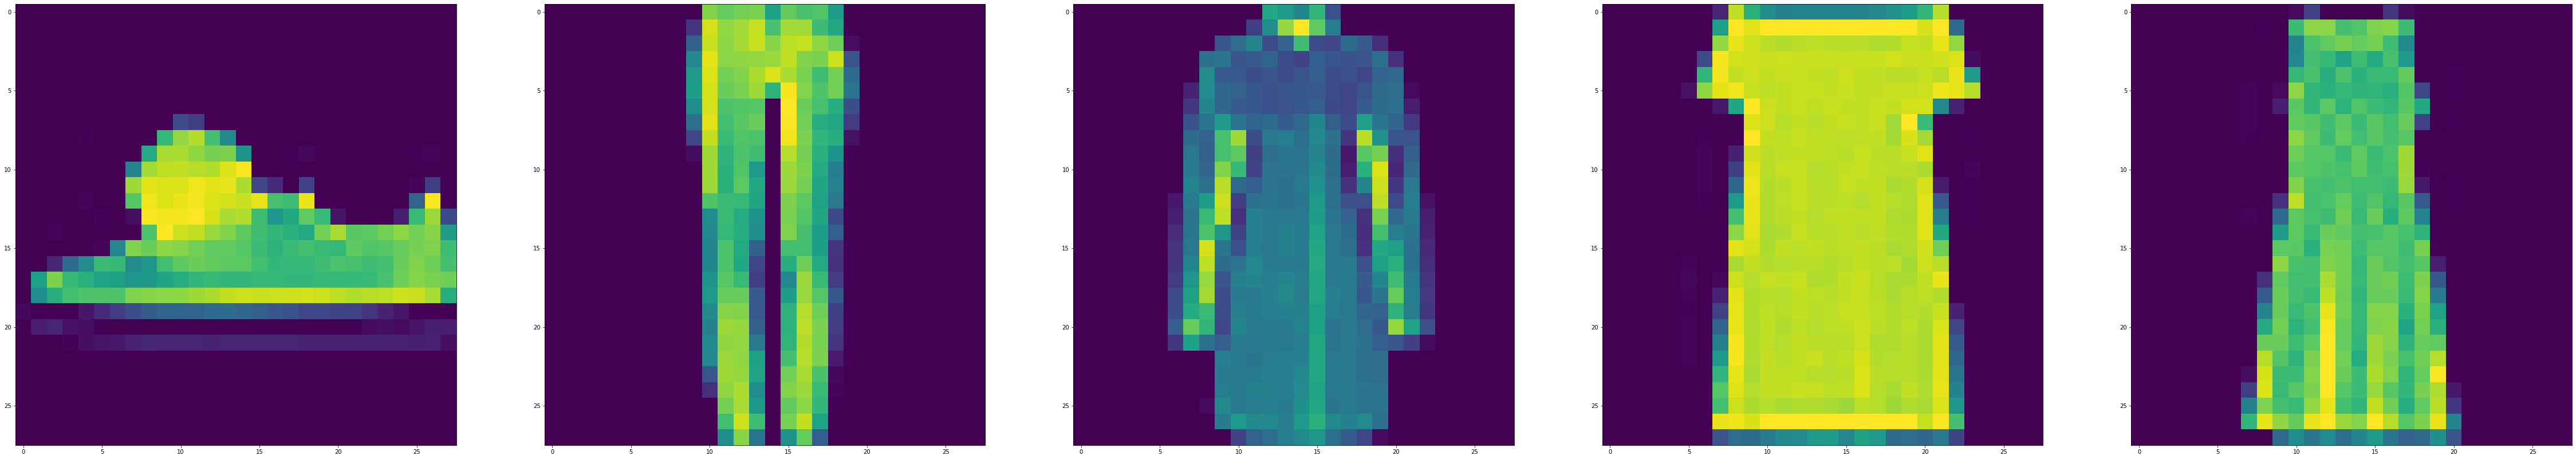

In [9]:
from PIL import Image 
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5): ax[i].imshow(val_x[i].reshape(28, 28))
plt.show()

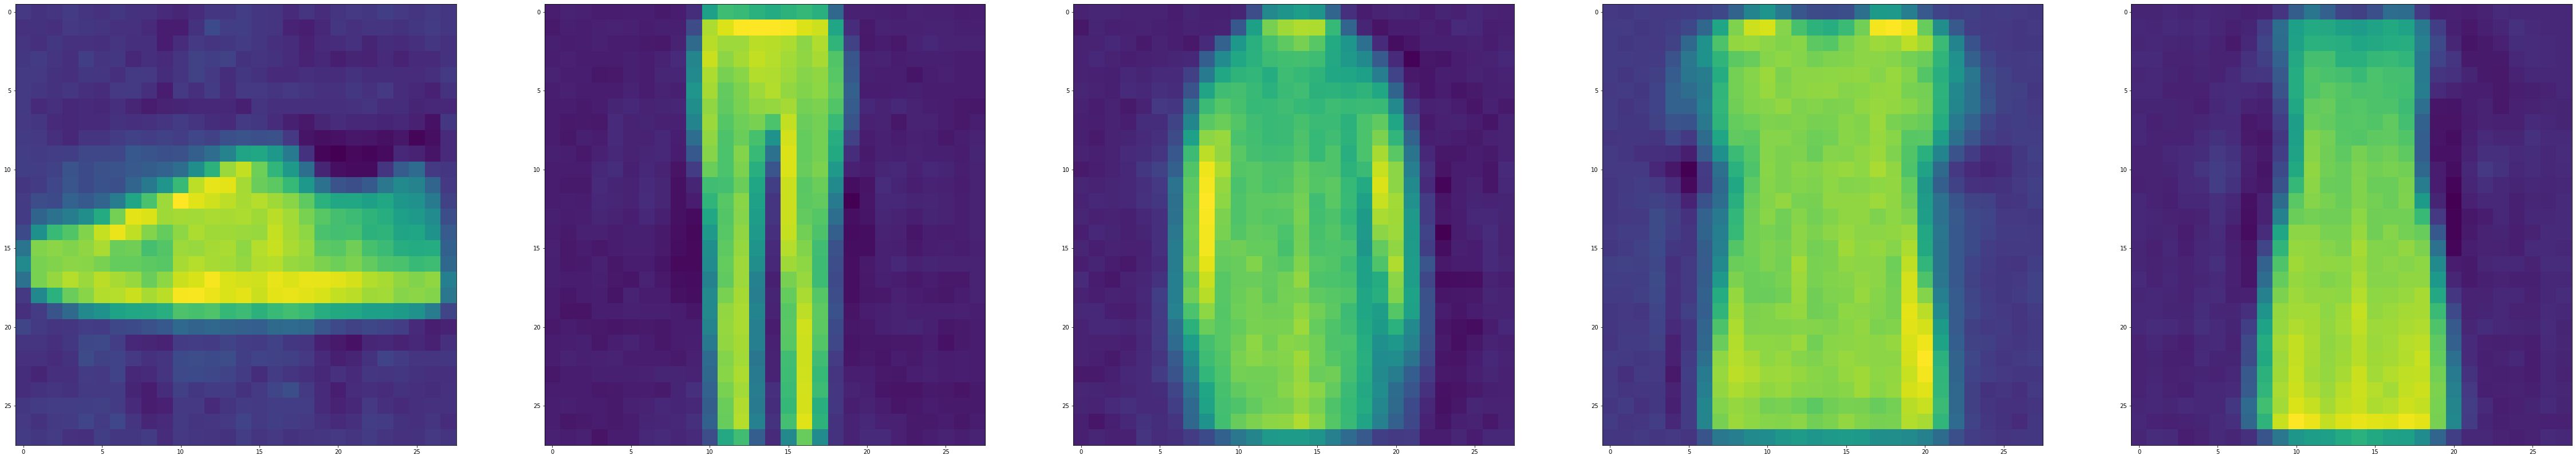

In [10]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5): ax[i].imshow(preds[i].reshape(28, 28))
plt.show()

# IMAGE DENOISING

In [11]:
train_x = train[list(train.columns)[1:]].values
train_x, val_x = train_test_split(train_x, test_size=0.2)
## normalize and reshape
train_x = train_x/255.
val_x = val_x/255.

In [12]:
train_x = train_x.reshape(-1, 28, 28, 1)
val_x = val_x.reshape(-1, 28, 28, 1)

In [13]:
noise = augmenters.SaltAndPepper(0.1)
seq_object = augmenters.Sequential([noise])
train_x_n = seq_object.augment_images(train_x * 255) / 255
val_x_n = seq_object.augment_images(val_x * 255) / 255

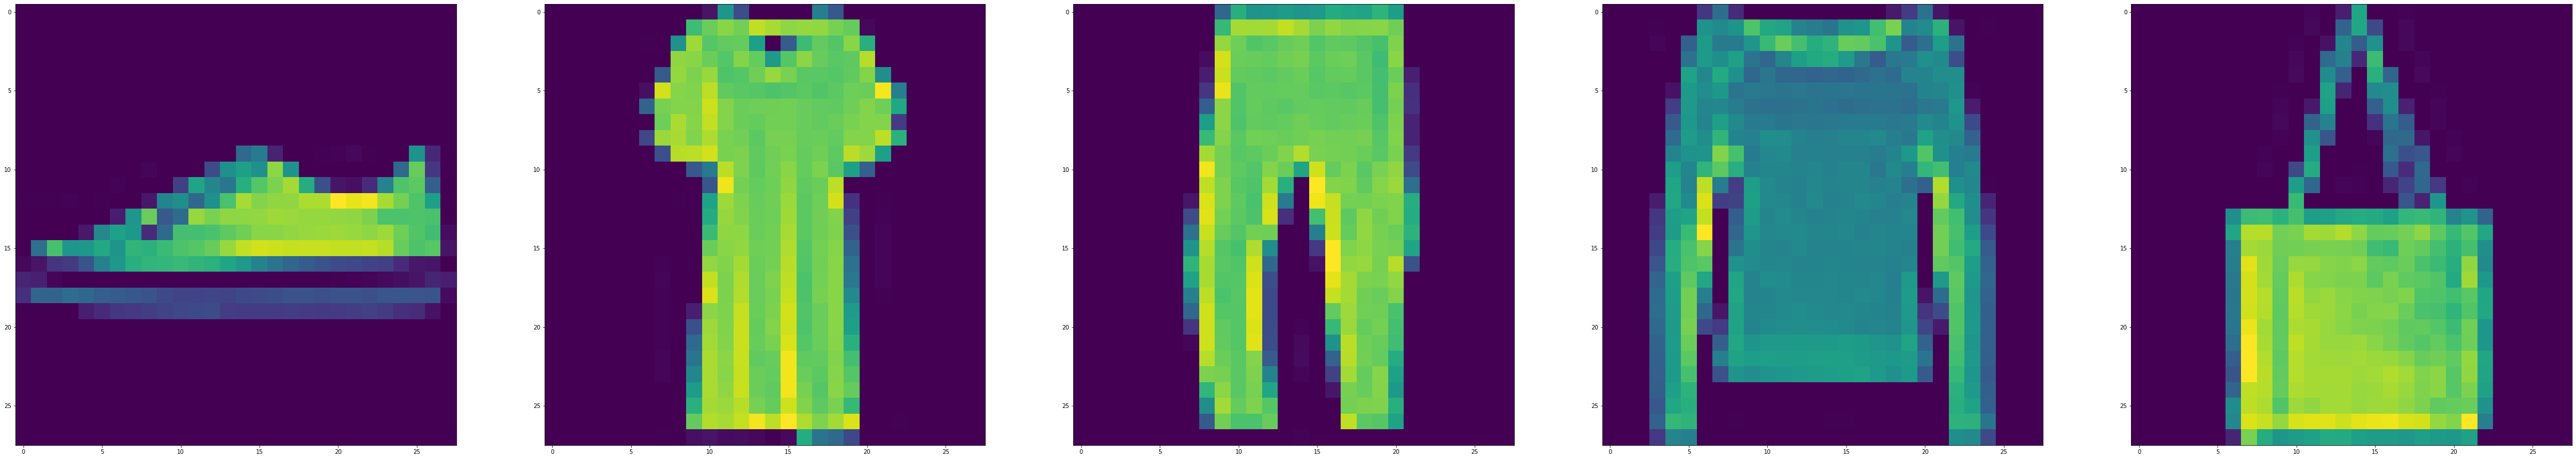

In [14]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5,10): ax[i-5].imshow(train_x[i].reshape(28, 28))
plt.show()

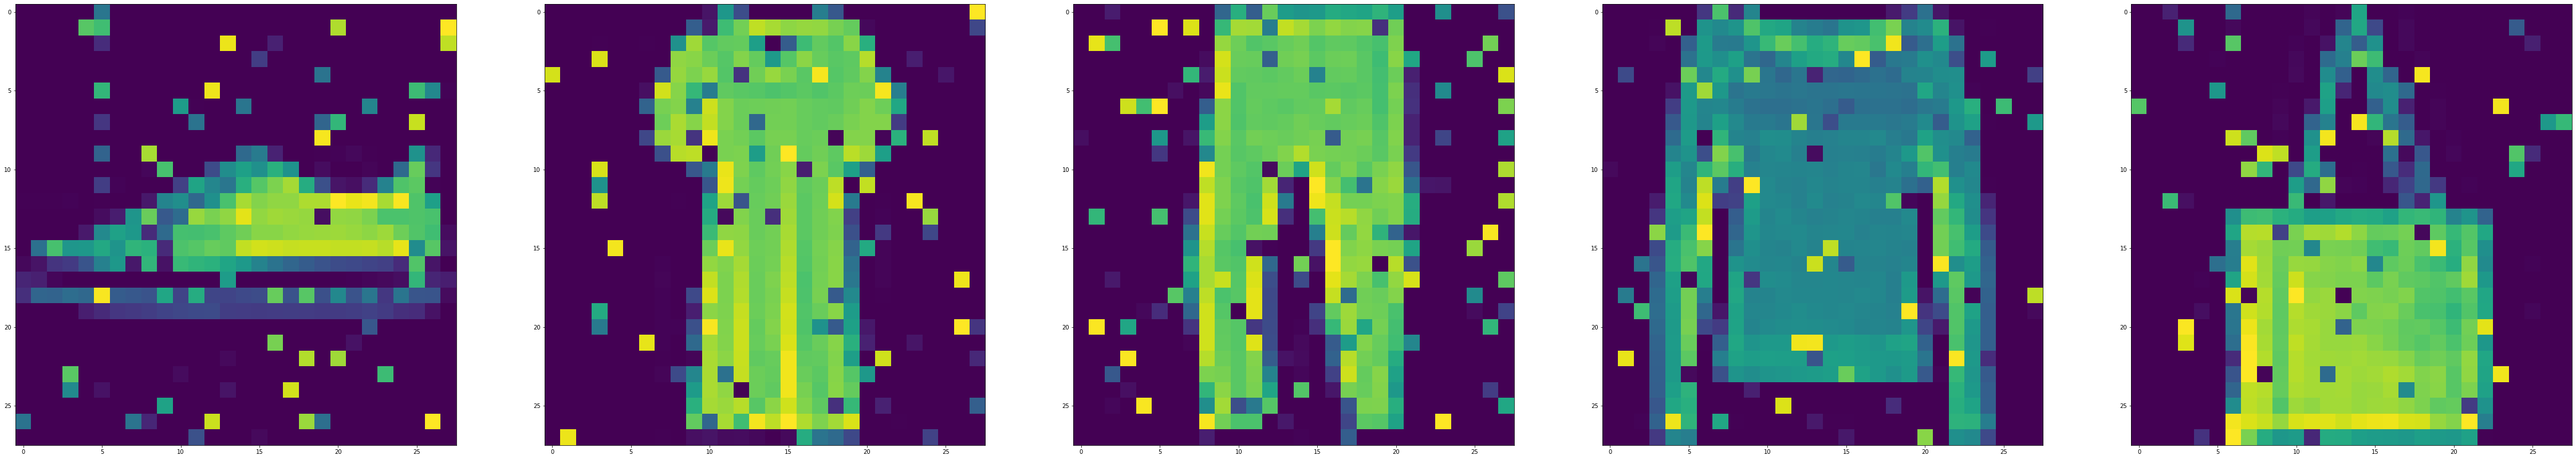

In [15]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5,10): ax[i-5].imshow(train_x_n[i].reshape(28, 28))
plt.show()

In [16]:
# input layer
input_layer = Input(shape=(28, 28, 1))
# encoding architecture
encoded_layer1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
encoded_layer1 = MaxPool2D( (2, 2), padding='same')(encoded_layer1)
encoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded_layer1)
encoded_layer2 = MaxPool2D( (2, 2), padding='same')(encoded_layer2)
encoded_layer3 = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded_layer2)
latent_view    = MaxPool2D( (2, 2), padding='same')(encoded_layer3)
# decoding architecture
decoded_layer1 = Conv2D(16, (3, 3), activation='relu', padding='same')(latent_view)
decoded_layer1 = UpSampling2D((2, 2))(decoded_layer1)
decoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded_layer1)
decoded_layer2 = UpSampling2D((2, 2))(decoded_layer2)
decoded_layer3 = Conv2D(64, (3, 3), activation='relu')(decoded_layer2)
decoded_layer3 = UpSampling2D((2, 2))(decoded_layer3)
output_layer   = Conv2D(1, (3, 3), padding='same')(decoded_layer3)
# compile the model
model_2 = Model(input_layer, output_layer)
model_2.compile(optimizer='adam', loss='mse')

In [17]:
model_2.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 16)          4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 16)         

In [18]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=5, mode='auto')
history = model_2.fit(train_x_n, train_x, epochs=10, batch_size=2048, validation_data=(val_x_n, val_x), callbacks=[early_stopping])

Epoch 1/10
24/24 [==============================] - 63s 3s/step - loss: 0.1014 - val_loss: 0.0597
Epoch 2/10
24/24 [==============================] - 64s 3s/step - loss: 0.0474 - val_loss: 0.0391
Epoch 3/10
24/24 [==============================] - 65s 3s/step - loss: 0.0354 - val_loss: 0.0324
Epoch 4/10
24/24 [==============================] - 65s 3s/step - loss: 0.0303 - val_loss: 0.0282
Epoch 5/10
24/24 [==============================] - 66s 3s/step - loss: 0.0270 - val_loss: 0.0257
Epoch 6/10
24/24 [==============================] - 69s 3s/step - loss: 0.0250 - val_loss: 0.0241
Epoch 7/10
24/24 [==============================] - 70s 3s/step - loss: 0.0236 - val_loss: 0.0229
Epoch 8/10
24/24 [==============================] - 69s 3s/step - loss: 0.0226 - val_loss: 0.0220
Epoch 9/10
24/24 [==============================] - 70s 3s/step - loss: 0.0217 - val_loss: 0.0212
Epoch 10/10
24/24 [==============================] - 70s 3s/step - loss: 0.0210 - val_loss: 0.0205


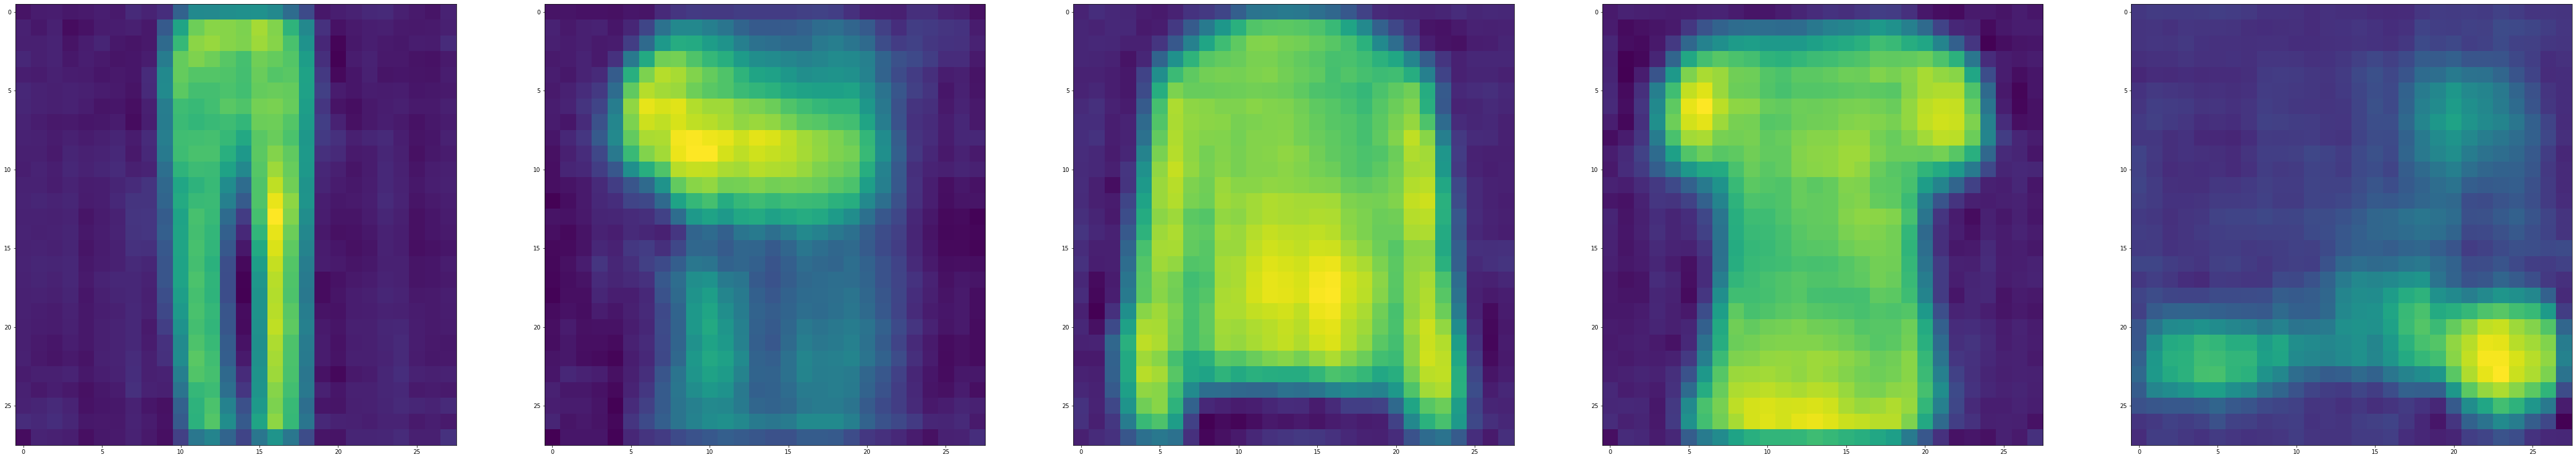

In [18]:
preds = model_2.predict(val_x_n[:10])
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5,10): ax[i-5].imshow(preds[i].reshape(28, 28))
plt.show()